In [1]:
"""
PCAM Baseline Model Training Notebook
This script loads the PCAM dataset, builds a simple ResNet50 model, and trains it for binary classification.
"""
import torch
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision import transforms, models, datasets
import torch.nn as nn
import torch.optim as optim

import h5py
import numpy as np
import matplotlib.pyplot as plt # For visualization
from collections import Counter

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# ============ CONFIGURATION ============
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
BATCH_SIZE = 32
NUM_EPOCHS = 5
LEARNING_RATE = 0.001
SUBSET_SIZE = 10000  # Use 10k samples for quick iteration
DATA_ROOT = './data'

print(f"Using device: {DEVICE}")

Using device: mps


In [6]:
# ============ DATA LOADING AND ANALYSIS ============
print("\n" + "="*60)
print("LOADING PCAM DATASET FOR VISUALISATION")
print("="*60 + "\n")


# Load datasets without transforms first (just for analysis)
train_dataset = datasets.PCAM(root='./data', split='train', download=True, transform=None)
val_dataset = datasets.PCAM(root='./data', split='val', download=True, transform=None)
test_dataset = datasets.PCAM(root='./data', split='test', download=True, transform=None)

print(f"Full dataset sizes:")
print(f"  Train: {len(train_dataset)}")
print(f"  Val: {len(val_dataset)}")
print(f"  Test: {len(test_dataset)}")


LOADING PCAM DATASET FOR VISUALISATION

Full dataset sizes:
  Train: 262144
  Val: 32768
  Test: 32768



Single Sample Structure:
  Image type: <class 'PIL.Image.Image'>
  Image shape: (96, 96)
  Image value range: min=0, max=255
  Label: 0 (type: <class 'int'>)

Sample visualization saved as 'pcam_samples.png'


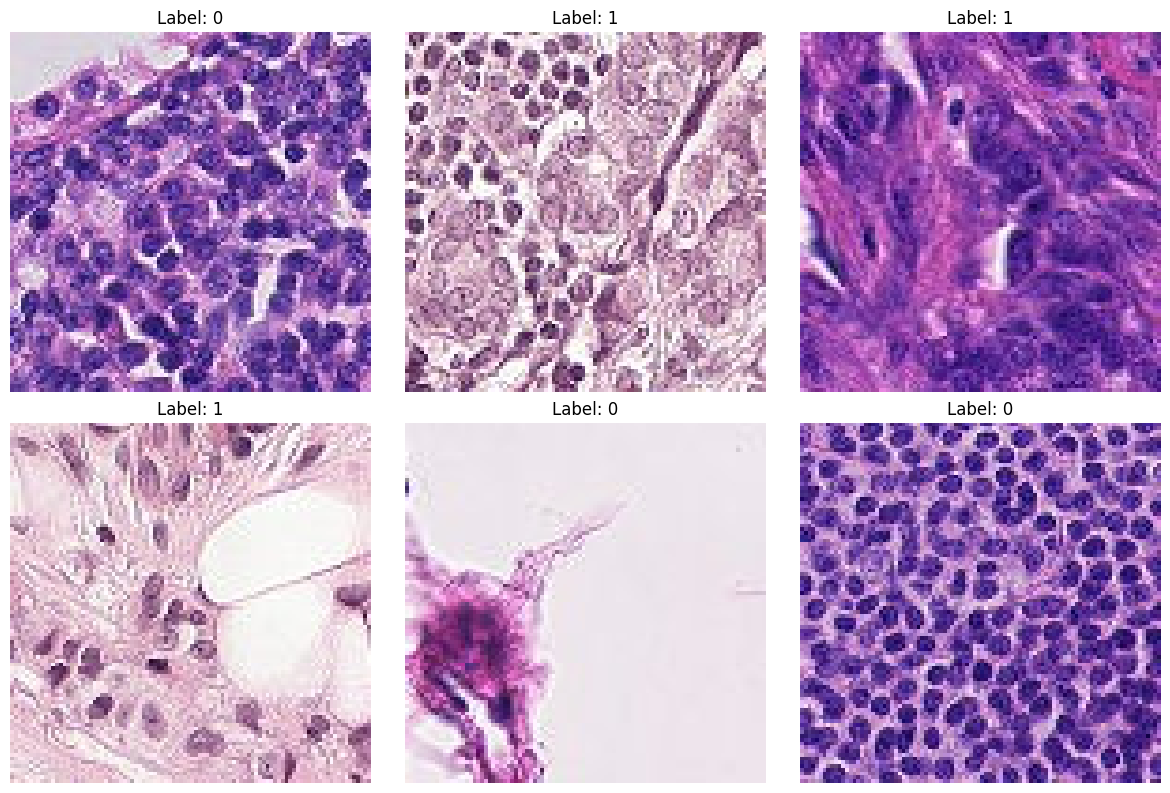

In [7]:
# Load a single sample to check structure
sample_image, sample_label = train_dataset[0]
print(f"\nSingle Sample Structure:")
print(f"  Image type: {type(sample_image)}")
print(f"  Image shape: {sample_image.size if hasattr(sample_image, 'size') else np.array(sample_image).shape}")
print(f"  Image value range: min={np.array(sample_image).min()}, max={np.array(sample_image).max()}")
print(f"  Label: {sample_label} (type: {type(sample_label)})")

# Visualize a few samples
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

for idx in range(6):
    image, label = train_dataset[idx]
    axes[idx].imshow(np.array(image))
    axes[idx].set_title(f"Label: {label}")
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('pcam_samples.png')
print(f"\nSample visualization saved as 'pcam_samples.png'")

In [8]:
# ============ DATA LOADING AND ANALYSIS ============
print("\n" + "="*60)
print("LOADING PCAM DATASET WITH TRANSFORMATION")
print("="*60 + "\n")

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),           # Convert to PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize
])

# Load datasets without transforms first (just for analysis)
train_dataset = datasets.PCAM(root='./data', split='train', download=True, transform=transform)
val_dataset = datasets.PCAM(root='./data', split='val', download=True, transform=transform)
test_dataset = datasets.PCAM(root='./data', split='test', download=True, transform=transform)

print(f"Full dataset sizes:")
print(f"  Train: {len(train_dataset)}")
print(f"  Val: {len(val_dataset)}")
print(f"  Test: {len(test_dataset)}")


LOADING PCAM DATASET WITH TRANSFORMATION

Full dataset sizes:
  Train: 262144
  Val: 32768
  Test: 32768


In [ ]:
# Check class distribution
print(f"\nClass Distribution:")

train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]
val_labels = [val_dataset[i][1] for i in range(len(val_dataset))]
test_labels = [test_dataset[i][1] for i in range(len(test_dataset))]

train_counts = Counter(train_labels)
val_counts = Counter(val_labels)
test_counts = Counter(test_labels)

print(f"  Train - Class 0: {train_counts[0]}, Class 1: {train_counts[1]}")
print(f"  Val - Class 0: {val_counts[0]}, Class 1: {val_counts[1]}")
print(f"  Test - Class 0: {test_counts[0]}, Class 1: {test_counts[1]}")

In [9]:
# Create subset for faster iteration
subset_indices = torch.randperm(len(train_dataset))[:SUBSET_SIZE].tolist()
train_subset = Subset(train_dataset, subset_indices)

# Create proportional val subset
val_subset_size = int(SUBSET_SIZE * 0.2)
val_indices = torch.randperm(len(val_dataset))[:val_subset_size].tolist()
val_subset = Subset(val_dataset, val_indices)

print(f"\nSubset sizes (for training):")
print(f"  Train subset: {len(train_subset)}")
print(f"  Val subset: {len(val_subset)}")


Subset sizes (for training):
  Train subset: 10000
  Val subset: 2000


In [10]:
# Create data loaders
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Verify data loading
batch_images, batch_labels = next(iter(train_loader))
print(f"\nBatch verification:")
print(f"  Batch images shape: {batch_images.shape}")
print(f"  Batch labels shape: {batch_labels.shape}")


Batch verification:
  Batch images shape: torch.Size([32, 3, 96, 96])
  Batch labels shape: torch.Size([32])


In [14]:
class PCamModel(nn.Module):
    def __init__(self, num_classes=2, pretrained=False):
        super().__init__()
        self.num_classes = num_classes
        self.resnet = models.resnet50(pretrained=pretrained)
        self.num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(self.num_ftrs, num_classes)
    
    def forward(self, x):
        return self.resnet(x)
    
model = PCamModel(num_classes=2, pretrained=False)
print(f"Model created: ResNet50 with {model.num_classes} output classes")

# Test forward pass
test_output = model(batch_images)
print(f"Test forward pass output shape: {test_output.shape}")

Model created: ResNet50 with 2 output classes
Test forward pass output shape: torch.Size([32, 2])


In [15]:
# ============ TRAINING ============
print("\n" + "="*60)
print("TRAINING MODEL")
print("="*60 + "\n")

def train_model(model, train_loader, val_loader, num_epochs, device):
    """
    Train the model with validation after each epoch
    """
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        avg_train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = val_correct / val_total
        
        # Store history
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)
        
        # Print metrics
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")
        print()
    
    return model, history

trained_model, training_history = train_model(model, train_loader, val_loader, NUM_EPOCHS, DEVICE)




TRAINING MODEL

Epoch 1/5
  Train Loss: 0.5395 | Train Acc: 0.7614
  Val Loss: 0.4532 | Val Acc: 0.7785

Epoch 2/5
  Train Loss: 0.4357 | Train Acc: 0.8073
  Val Loss: 0.6437 | Val Acc: 0.7460

Epoch 3/5
  Train Loss: 0.4188 | Train Acc: 0.8158
  Val Loss: 0.5830 | Val Acc: 0.7285

Epoch 4/5
  Train Loss: 0.3983 | Train Acc: 0.8245
  Val Loss: 0.4656 | Val Acc: 0.7980

Epoch 5/5
  Train Loss: 0.3884 | Train Acc: 0.8298
  Val Loss: 0.4635 | Val Acc: 0.7995



In [16]:
# ============ EVALUATION ============
print("\n" + "="*60)
print("EVALUATING ON TEST SET")
print("="*60 + "\n")

def evaluate_model(model, test_loader, device):
    """
    Evaluate model on test set
    """
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    return accuracy

test_accuracy = evaluate_model(trained_model, test_loader, DEVICE)
print(f"Test Accuracy: {test_accuracy:.4f}")



EVALUATING ON TEST SET

Test Accuracy: 0.7684


In [17]:
#============ SAVE MODEL ============
print("\n" + "="*60)
print("SAVING MODEL")
print("="*60 + "\n")

torch.save(trained_model.state_dict(), 'pcam_baseline_model.pth')
print("Model saved as 'pcam_baseline_model.pth'")



SAVING MODEL

Model saved as 'pcam_baseline_model.pth'



Generating training history plots...
Training history plot saved as 'training_history.png'

TRAINING COMPLETE


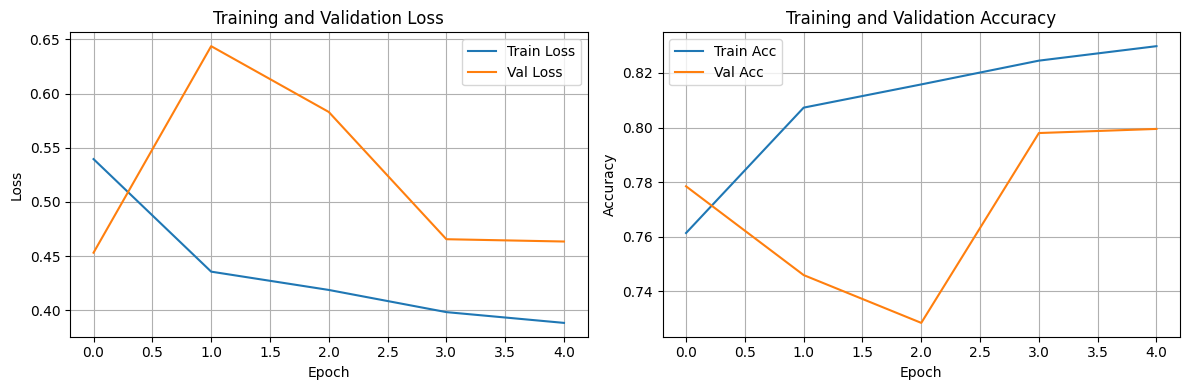

In [18]:
# ============ VISUALIZATION ============
print("\nGenerating training history plots...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot loss
ax1.plot(training_history['train_loss'], label='Train Loss')
ax1.plot(training_history['val_loss'], label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracy
ax2.plot(training_history['train_acc'], label='Train Acc')
ax2.plot(training_history['val_acc'], label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=100)
print("Training history plot saved as 'training_history.png'")

print("\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)